## Oscillons

In [1]:
cd '/home/dpirvu/project/bubbles/'

/home/dpirvu/project/bubbles


In [2]:
import os,sys
sys.path.append('/home/dpirvu/python_stuff/')
sys.path.append('/home/dpirvu/project/bubbles/bubble_codes/')
#sys.path.append('/home/dpirvu/project/bubbles/bubble_codes_older/')
#sys.path.remove('/home/dpirvu/DarkPhotonxunWISE/hmvec-master')
print(sys.path)
from plotting import *
from bubble_tools import *
from experiment import *
from celluloid import Camera

from itertools import chain
import operator
import pywt

%matplotlib inline

['/home/dpirvu/project/bubbles', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/home/dpirvu/DarkPhotonxunWISE/hmvec-master', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython', '/home/dpirvu/python_stuff/', '/home/dpirvu/project/bubbles/bubble_codes/']
['/home/dpirvu/project/bubbles', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/home/dpirvu/DarkPhotonxunWISE/hmvec-master', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.

In [ ]:
######################################
# Tools for oscillons

def find_nucleation_center(bubble, phi_init, crit_thresh, crit_rad):
    T, N = np.shape(bubble)

    bubble_counts = np.count_nonzero(bubble >= crit_thresh, axis=1)
    t0 = np.argmin(np.abs(bubble_counts - crit_rad))

    bubble_counts = np.count_nonzero(bubble >= crit_thresh, axis=0)
    x0 = np.argmax(bubble_counts)

    return min(T-1,t0), min(N-1,x0)

def get_bubble(exp_params, sim, crit_thresh, crit_rad, minduration):
    path2CLEANsim = clean_sim_location(*exp_params, sim)
    bubble = np.load(path2CLEANsim)

    real = np.abs(bubble[0])
    
    # smoothing recommended
    real = gaussian_filter(real, 1.5, mode='nearest')
    
    tcen, xcen = find_nucleation_center(real, phieq, crit_thresh, crit_rad)

    if tcen - minduration < 0:
        return None
    ind = max(0, tcen - minduration)
    return bubble[0, ind:tcen, :]

def get_HT(array):  
    array = array - np.mean(array)
    w  = np.fft.fftfreq(len(array), d=1) * len(array)
    FD = np.fft.fft(array, axis=0)
    FD[w<=0.,:] = 0.
    FD[w>0.,:] *= 2.
    HD = np.fft.ifft(FD, axis=0)
    return np.abs(HD)

def get_osc_trajectory(array, row, col, extent):
    T, N = np.shape(array)
    maxLine = []
    CCol = col
    for rr in range(row)[::-1]:
        if rr == row-1:
            col = CCol
        colmin = col - extent
        colmax = col + extent+1
        val = 0
        for cc in range(colmin, colmax):
            cc = cc%N
            if array[rr][cc] > val:
                val = array[rr][cc]
                col = cc
        maxLine.append(col)
    maxLine = maxLine[::-1]
    for rr in range(row, T):
        if rr == row:
            col = CCol
        colmin = col - extent
        colmax = col + extent+1
        val = 0
        for cc in range(colmin, colmax):
            cc = cc%N
            if array[rr][cc] > val:
                val = array[rr][cc]
                col = cc
        maxLine.append(col)
    return np.array(maxLine)

# average oscillon trajectories
def tolerant_mean(arrs):
    lens = np.array([len(i) for i in arrs])
    arr  = np.zeros((len(lens), np.max(lens)))
    arr[:] = np.nan
    for ri, osc in enumerate(arrs):
        arr[ri, :len(osc)] = osc
    return np.nanmean(arr, axis=0), np.nanstd(arr, axis=0)

def flatten_comprehension(matrix):
    return np.array([item for row in matrix for item in row])

def flatten_comprehension2(matrix):
    return np.array([np.abs(np.round(item,10)) for row in matrix for item in row])


In [6]:
case = 'minus'
general = get_general_model(case)
tempList, massq, right_Vmax, V, dV, Vinv, nTimeMAX, minSim, maxSim = general

tmp = 0
temp, m2, sigmafld = get_model(*general, tmp)
exp_params = [nLat, m2, temp]
print('Experiment', exp_params)


Experiment [2048, 0.85, 0.1]


In [7]:
# Sims that decayed
simLists, notsimLists = [], []
for sim in range(minSim, maxSim):
    path2CLEANsim = clean_sim_location(*exp_params, sim)
    if os.path.exists(path2CLEANsim):
        simLists.append(sim)
simLists = np.array(simLists)
print(np.shape(simLists))


(277,)


In [8]:
# Critical bubble size in lattice units
crit_rad = 30

# Critical bubble amplitude
crit_thresh = 1.41479

# How far to look for peak at t-1
deltae = int(2*crit_rad)

# All sims must have the same duration in lattice units:
minduration = nLat//3

In [9]:
deltae*dx

2.9296875

In [35]:
save_oscillons_stats = True
if save_oscillons_stats:

    all_saved_data, all_saved_frequency_data = [], []
    for si, sim in enumerate(simLists):
        bubble = get_bubble(exp_params, sim, crit_thresh, crit_rad, minduration)
        try:
            nT, nN   = np.shape(bubble)
            max_idx  = np.argmax(np.abs(bubble))
            row, col = np.divmod(max_idx, nN)
            if bubble[row,col] < 0:
                bubble = -bubble
        except:
            continue

        aHT = get_HT(bubble)
        trajct = get_osc_trajectory(aHT, row, col, extent=deltae)
        bubble = gaussian_filter(bubble, 1, mode='nearest')
        precursor = bubble[np.arange(nT), trajct][::-1]

        nT, nN   = np.shape(bubble)

        # Here I assume that the speed of light is 1 in the data
        random_angle = np.random.randint(-100, 100)/100
        xrand = col + np.arange(nT)*random_angle
        xrand = np.array([int(i) for i in xrand%nN])[::-1]
        nullOscillon = bubble[np.arange(nT), xrand][::-1]

        all_saved_data.append(np.array([sim, trajct, precursor, xrand, nullOscillon]))
    np.save('./plots/precursor_oscillon_data.npy', all_saved_data)

    all_saved_data = np.load('./plots/precursor_oscillon_data.npy', allow_pickle=True)
    simLists, all_trajcts, all_precursors, all_null_rays, all_null_precursors = all_saved_data.T

    for si, sim in enumerate(simLists):
        precursor = all_precursors[si]
        null_precursor = all_null_precursors[si]
        nT = len(precursor)

        fft_oscillon = np.fft.fft(precursor, norm='forward')
        freqs = np.fft.fftfreq(nT, d=1) * nT
        PS_precursor = np.abs(fft_oscillon)**2.
        max_ind_precursor = np.argmax(PS_precursor[freqs>0])

        fft_null_precursor = np.fft.fft(null_precursor, norm='forward')
        PS_null_precursor = np.abs(fft_null_precursor)**2.
        max_ind_null_precursor = np.argmax(PS_null_precursor[freqs>0])

        all_saved_frequency_data.append(np.array([freqs, max_ind_precursor, PS_precursor, max_ind_null_precursor, PS_null_precursor]))
    np.save('./plots/precursor_fft_oscillon_data.npy', all_saved_frequency_data)


/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
print('Importing data.')

all_saved_data = np.load('./plots/precursor_oscillon_data.npy', allow_pickle=True)
simLists, all_trajcts, all_precursors, all_null_rays, all_null_precursors = all_saved_data.T
print('Working with', len(simLists), 'precursors.')

all_saved_frequency_data = np.load('./plots/precursor_fft_oscillon_data.npy', allow_pickle=True)
all_freqs, max_indxs_precursor, PS_precursors, max_indxs_null_precursor, PS_null_precursors = all_saved_frequency_data.T

print('Calculating averages.')
maxduration = minduration

av_OS, error_OS = tolerant_mean(all_precursors)
av_null, error_null = tolerant_mean(all_null_precursors)

av_PS_OS, error_PS_OS = tolerant_mean(PS_precursors)
av_PS_null, error_PS_null = tolerant_mean(PS_null_precursors)

avfq, err = tolerant_mean(all_freqs)
test = np.all(avfq - random.choice(all_freqs)) == 0
print(('All good.' if test else 'Error.'))


Importing data.
Working with 58 precursors.
Calculating averages.
All good.


Bubble precursor data shown in green. Random angle rays in the past lightcone of the nucleation coordinate shown in black.
SIMULATION 14


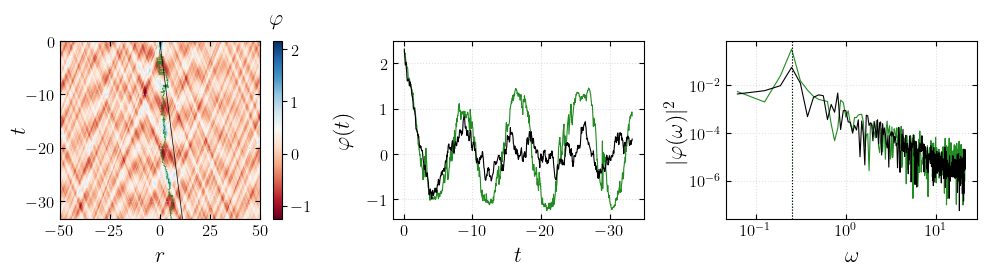

SIMULATION 152


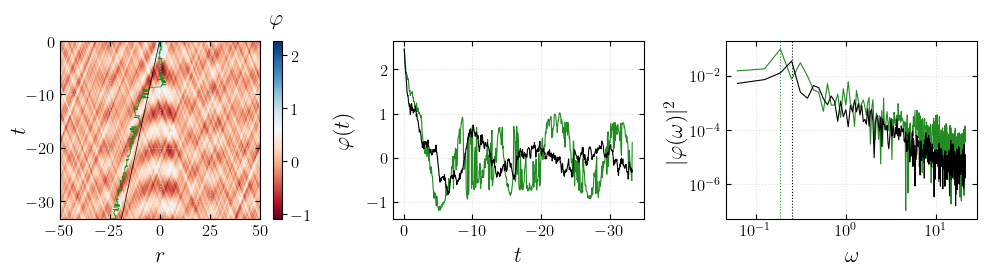

SIMULATION 254


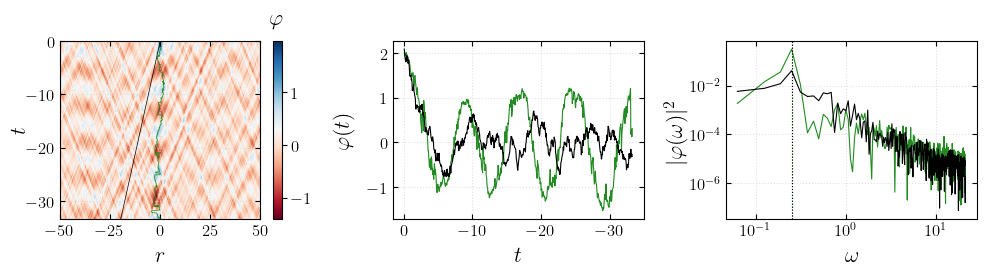

SIMULATION 353


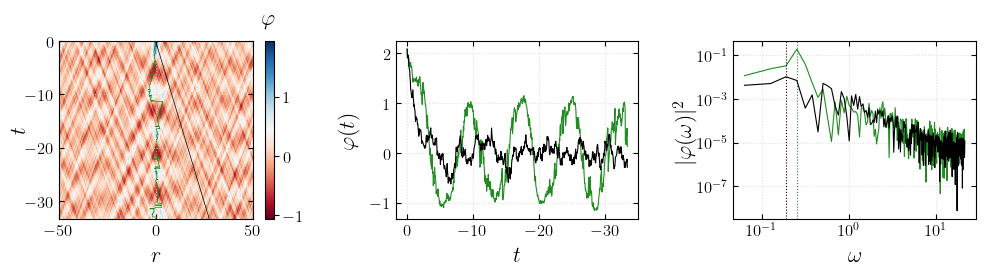

SIMULATION 455


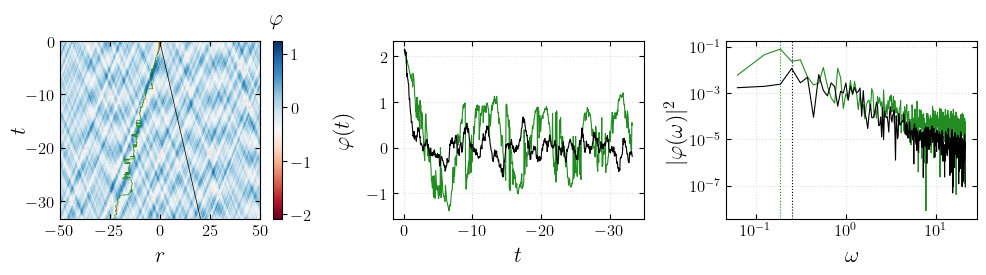

SIMULATION 558


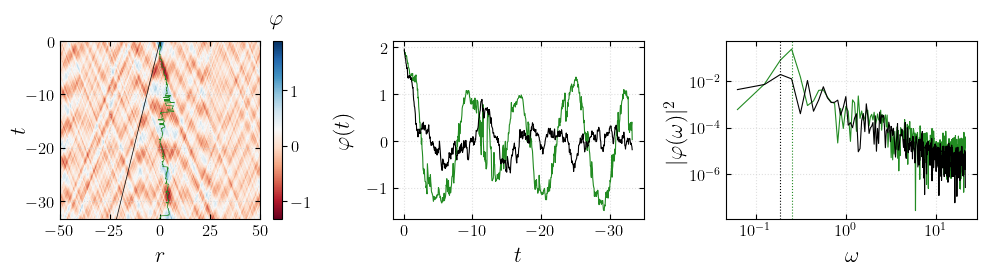

In [34]:
print('Bubble precursor data shown in green. Random angle rays in the past lightcone of the nucleation coordinate shown in black.')
for si, sim in enumerate(simLists):
    if si%10!=1: continue
    print('SIMULATION', sim)

    bubble = get_bubble(exp_params, sim, crit_thresh, crit_rad, minduration)
    nT, nN = np.shape(bubble)

    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    exts = np.array([-nN//2,nN//2,-nT,0]) * dx
    im = ax[0].imshow(bubble, extent=exts, aspect='auto', interpolation='none', origin='lower', cmap='RdBu') #original
    ax[0].set_xlabel(r'$r$', fontsize=16)
    ax[0].set_ylabel(r'$t$', fontsize=16)
    cbar = fig.colorbar(im, ax=ax[0])
    cbar.ax.set_title(r'$\varphi$', fontsize=16)

    maxln1 = all_trajcts[si]
    precursor = all_precursors[si]
    ylist = (np.arange(len(maxln1))-nT) * dx
    ax[0].plot((maxln1 - nN//2) * dx, ylist, ls='-', color='forestgreen', linewidth=0.5)

    maxln1 = all_null_rays[si] - nN//2
    null_precursor = all_null_precursors[si]
    ax[0].plot(maxln1 * dx, ylist, ls='-', color='k', linewidth=0.5)

    ax[1].plot(ylist, precursor[::-1], color='forestgreen', ls='-', lw=0.8)
    ax[1].plot(ylist, null_precursor[::-1], color='k', ls='-', lw=0.8)
    ax[1].invert_xaxis()

    freqs = all_freqs[si]
    psyfd = PS_precursors[si]
    ind = max_indxs_precursor[si]

    ax[2].axvline(freqs[freqs>0][ind] * dk, ls=':', color='forestgreen', lw=0.8)
    ax[2].loglog(freqs[freqs>0] * dk, psyfd[freqs>0], color='forestgreen', linewidth=0.8)

    psyfd = PS_null_precursors[si]
    ind = max_indxs_null_precursor[si]

    ax[2].axvline(freqs[freqs>0][ind] * dk, ls=':', color='k', lw=0.8)
    ax[2].loglog(freqs[freqs>0] * dk, psyfd[freqs>0], color='k', linewidth=0.8)


    ax[1].set_xlabel(r'$t$', fontsize=16)
    ax[1].set_ylabel(r'$\varphi(t)$', fontsize=16)

    ax[2].set_xlabel(r'$\omega$', fontsize=16)
    ax[2].set_ylabel(r'$|\varphi(\omega)|^2$', fontsize=16)

    beautify_nolegs(ax, times=-100)
    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


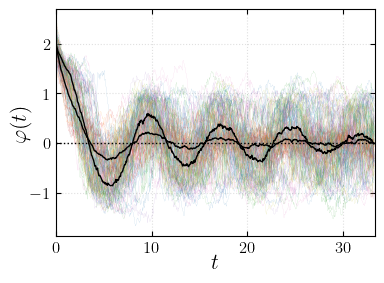

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (4, 3))

for si, sim in enumerate(simLists):
    precursor = all_precursors[si]
    traj = all_trajcts[si]
    null_precursor = all_null_precursors[si]

    ax.plot(dx * np.arange(len(traj)),      precursor, lw=0.05)
    ax.plot(dx * np.arange(len(traj)), null_precursor, lw=0.05)

#ax.errorbar(dx * np.arange(maxduration), av_OS  , yerr=error_OS/len(simLists)**0.5,   lw=1, color='k', ecolor='r')
#ax.errorbar(dx * np.arange(maxduration), av_null, yerr=error_null/len(simLists)**0.5, lw=1, color='k', ecolor='r')
ax.plot(dx * np.arange(maxduration), av_OS  , lw=1, color='k')
ax.plot(dx * np.arange(maxduration), av_null, lw=1, color='k')

for ai, aax in enumerate([ax]):
    aax.axhline(phieq, ls=':', color='k', lw=1)
    aax.set_xlabel(r'$t$', fontsize=16)
    aax.set_xlim(0, maxduration*dx)
ax.set_ylabel(r'$\varphi(t)$', fontsize=16)
beautify(ax, times=-50)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


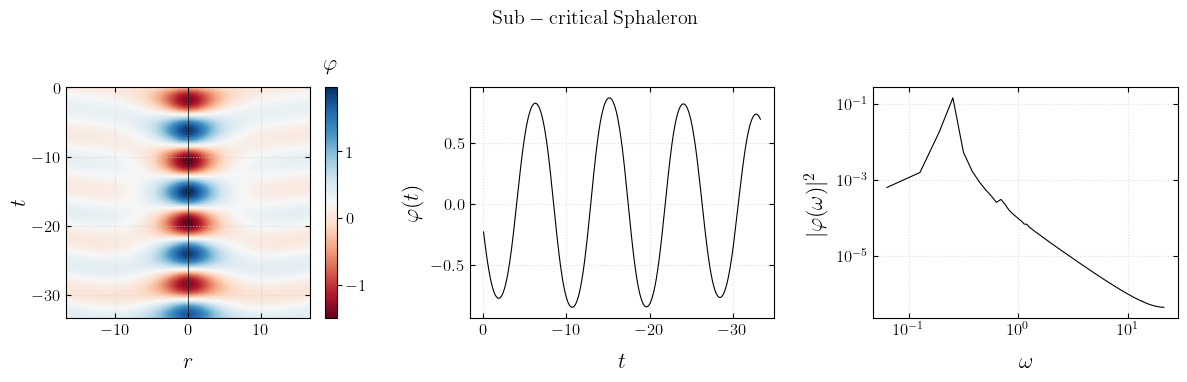

In [24]:
precursor_sim = np.load('./plots/precursor.npy')
if len(precursor_sim) < maxduration:
    print('Decrease the precursor duration.')
precursor_sim = precursor_sim[::-1][:maxduration]
precursor_sim = precursor_sim - np.mean(precursor_sim)

max_idx  = np.argmax(np.abs(precursor_sim))
row, col = np.divmod(max_idx, nN)
nT, nN   = np.shape(precursor_sim)
aHD_prec = get_HT(precursor_sim)
l2 = get_osc_trajectory(aHD_prec, row, col, extent=deltae)
subcritical = precursor_sim[np.arange(nT), l2][::-1]

y_fft = np.fft.fft(subcritical, norm='forward') 
ps_subcritical = np.abs(y_fft)**2.

plots = True
if plots:
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    plt.suptitle(r'$\rm Sub-critical \; Sphaleron$')
    exts = np.array([-nN//2,nN//2,-nT,0]) * dx
    im1 = ax[0].imshow(precursor_sim, aspect='auto', interpolation='none', extent=exts, origin='lower', cmap='RdBu')
    ax[0].set_xlabel(r'$r$', fontsize=16)
    ax[0].set_ylabel(r'$t$', fontsize=16)
    cbar = fig.colorbar(im, ax=ax[0])
    cbar.ax.set_title(r'$\varphi$', fontsize=16)

    ylist = (np.arange(len(l2))-nT) * dx
    ax[0].plot((l2 - nN//2) * dx, ylist, ls='-', color='k', linewidth=0.5)

    ax[1].plot(ylist, subcritical[::-1], color='k', ls='-', lw=0.8)
    ax[1].invert_xaxis()

    ax[2].loglog(avfq[avfq>0] * dk, ps_subcritical[avfq>0], color='k', linewidth=0.8)

    ax[1].set_xlabel(r'$t$', fontsize=16)
    ax[1].set_ylabel(r'$\varphi(t)$', fontsize=16)
    ax[2].set_xlabel(r'$\omega$', fontsize=16)
    ax[2].set_ylabel(r'$|\varphi(\omega)|^2$', fontsize=16)

    beautify(ax, times=-100)
    plt.tight_layout()
    plt.show()


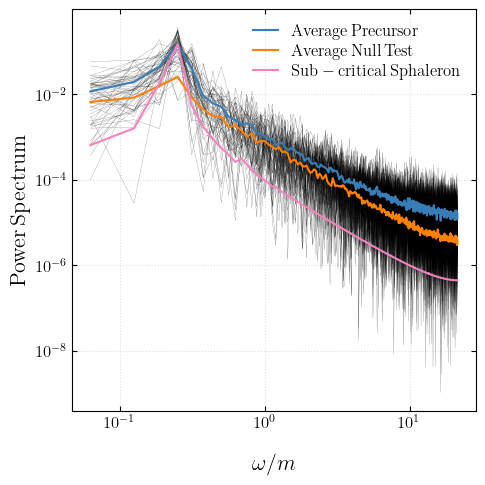

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for si, sim in enumerate(simLists):
    precursor = all_precursors[si]
    null_precursor = all_null_precursors[si]
    freqs = all_freqs[si]
    PS_precursor = PS_precursors[si]
    PS_null_precursor = PS_null_precursors[si]

    plt.plot(avfq[avfq>0]*dk, PS_precursor[avfq>0], linewidth=0.1, color='k')
#    plt.plot(avfq[avfq>0]*dk, PS_null_precursor[avfq>0], linewidth=0.1, color='k')

plt.plot(avfq[avfq>0]*dk, av_PS_OS[avfq>0],       color=allcolors[0], label=r'$\rm Average \, Precursor$')
plt.plot(avfq[avfq>0]*dk, av_PS_null[avfq>0],     color=allcolors[1], label=r'$\rm Average \, Null \, Test$')
plt.plot(avfq[avfq>0]*dk, ps_subcritical[avfq>0], color=allcolors[3], label=r'$\rm Sub-critical \, Sphaleron$')

ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel(r'$\omega / m$', fontsize=16)
plt.ylabel(r'$\rm Power \, Spectrum$', fontsize=16)

beautify(ax, times=-70)
plt.tight_layout()
plt.show()